# Assignment 7

Andrew Loeppky

ATSC 595 - Dr. R. Stull

Fall 2021

### Part A(1)

For each chemical reaction { } listed above, how many eqs apply, and what is the resulting total number of equations?

**{01'}** 1 R definition, 3 rate eqs = 4 equations


**{03}** 1 R definition, 3 rate eqs = 4 equations


**{09}** 1 R def, 2 rate eqs = 3 equations


**{11}** 1 R def, 2 rate eqs = 3 equations


**{25}** 1 R def, 4 rate eqs = 5 equations


**{123}** 1 R def, 3 rate eqs = 4 equations


**Total** = 23

### Part A(2) 

For each one of the 7 chemicals that we want to forecast, how many R production/loss terms apply?

$CO$ - 0 prod, 1 loss

$HO_2$ - 1 prod, 1 loss

$NO$ - 1 prod, 2 loss

$NO_2$ - 2 prod, 1 loss

$O_{1D}$ - 1 prod, 1 loss

$O_3$ - 1 prod, 2 loss

$OH$ - 2 prod, 1 loss


### Part B

Write all of the reaction eqs (similar to {25.0 to 25.4} shown above).
But don't include reaction eqs for items in parenthesis ( ), or for
any variable we assume is constant.

#### Equation {01'}

$$
R_{01} = j_{01}[NO_2]\tag{01.0}
$$

$$
\dot{[NO_2]} = -R_{01}\tag{01.1}
$$

$$
\dot{[NO]} = R_{01}\tag{01.2}
$$

$$
\dot{[O_3]} = R_{01}\tag{01.3}
$$

#### Equation {03}

$$
R_{03} = k_{03}[0_3][NO]\tag{03.0}
$$

$$
\dot{[O_3]} = -R_{03}\tag{03.1}
$$

$$
\dot{[NO]} = -R_{03}\tag{03.2}
$$

$$
\dot{[NO_2]} = R_{03}\tag{03.3}
$$

#### Equation {09}

$$
R_{09} = j_{09}[O_3]\tag{09.0}
$$

$$
\dot{[O_3]} = -R_{09}\tag{09.1}
$$

$$
\dot{[O_{1D}]} = R_{09}\tag{09.2}
$$

#### Equation {11}

$$
R_{11} = k_{11}[O_{1D}][H_2O]\tag{11.0}
$$

$$
\dot{[O_{1D}]} = -R_{11}\tag{11.1}
$$

$$
\dot{[OH]} = 2R_{11}\tag{11.2}
$$

#### Equation {25}

$$
R_{25} = k_{25}[H_2O][NO_2]\tag{25.0}
$$

$$
\dot{[OH]} = R_{25}\tag{25.1}
$$

$$
\dot{[NO_2]} = R_{25}\tag{25.2}
$$

$$
\dot{[HO_2]} = -R_{25}\tag{25.3}
$$

$$
\dot{[NO]} = -R_{25}\tag{25.4}
$$

#### Equation {123}

$$
R_{123} = k_{123}[OH][CO]\tag{123.0}
$$

$$
\dot{[OH]} = -R_{123}\tag{123.1}
$$

$$
\dot{[CO]} = - R_{123}\tag{123.2}
$$

$$
\dot{[HO_2]} = R_{123}\tag{123.3}
$$

### Part C

In your favorite programming language, write into your computer
program the finite difference form of the forecast eqs for each
of the 7 chemicals of interest.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

from IPython.display import clear_output

In [41]:
##################################################################
### assign numpy indices
# CO  -> 0
# HO2 -> 1
# NO  -> 2
# NO2 -> 3
# O1D -> 4
# O3  -> 5
# OH  -> 6

# initialize each species
initconcs = np.array([2.5e12, 0.0, 1.25e12, 1.25e11, 0.0, 0.0, 0.0])

##################################################################
# initialize rate constants (treat H2O conc as a constant)
j01 = 1.0e-3  # (units 1/s) for {01'}  NO2 + h·nu -> NO + O3
k03 = 1.73e-15  # (units (s · molecules/cm^3)^-1 ) for {03}   O3 + NO -> (O2) + NO2
j09 = 1.0e-6  # (units 1/s) for {09}   O3 + h·nu -> (O2) + O1D
k11 = 2.14e-10  # (units (s · molecules/cm^3)^-1 ) for {11} O1D + H2O -> 2 OH
k25 = 8.54e-12  # (units (s · molecules/cm^3)^-1 ) for {25} HO2 + NO -> OH + NO2
k123 = 2.28e-14  # units (s · molecules/cm^3)^-1 for {123} OH +CO +(O2)-> HO2 + (CO2)
H2O = 2.5e15  # molecules / cm^3  which is 0.01% of the air at sea level

####################################################################
# Time step info
delt_s = 0.0001  # time step (s) for your iterations
tend_h = 2.0  # duration of forecast (hours)
tsave_m = 2.0  # how often (minutes) to save results to plot

# convert everything to seconds
tend = tend_h * 3600
tsave = tsave_m * 60
delt = delt_s

# tiny sim for testing code
#tend = 1
#tsave = 0.1
#delt = 0.0001

In [51]:
@jit
def init(c0, tend, tsave):
    """
    concs:
        initializes a dataframe with columns for each chemical species,
        sets the first row to the specified initial concentrations c0
        
    initconcs:
        creates a 1-row array of c0 to pass to loop
    """
    time = np.arange(0, tend, tsave) # timesteps to save
    
    # create the master dataframe
    tseries = pd.DataFrame(columns=["CO", "HO2", "NO", "NO2", "O1D", "O3", "OH"], index=time)
    
    # fill first row with initial concentrations
    tseries.loc[time[0]] = c0
    
    return tseries, initconcs

#### Equations for combined production/loss of each species

$$
R_{CO} = -R_{123}
$$

$$
R_{HO2} = R_{123} - R_{25}
$$

$$
R_{NO} = R_{01} - R_{03} - R_{25}
$$

$$
R_{NO2} = -R_{01} + R_{03} + R_{25}
$$

$$
R_{O1D} = R_{09} - R_{11}
$$

$$
R_{O3} = R_{01} - R_{03} - R_{09} 
$$

$$
R_{OH} = 2R_{11} + R_{25} - R_{123}
$$

In [43]:
@jit
def step_fwd(c_old, delt):
    """
    this function holds all of the combined prod/loss equations
    """
    c_new = c_old
    
    # write out derivatives of each species as the sum of each relevant R value
    # this is a painful way to express the equations but it runs FAST
    c_new[0] += -(k123 * c_old[6] * c_old[0]) * delt
    c_new[1] += (k123 * c_old[6] * c_old[0] - k25 * c_old[1] * c_old[3]) * delt
    c_new[2] += ((j01 * c_old[3]) - (k03 * c_old[5] * c_old[2]) - (k25 * c_old[1] * c_old[3])) * delt
    c_new[3] += (-(j01 * c_old[3]) + (k03 * c_old[5] * c_old[2]) + (k25 * c_old[1] * c_old[3])) * delt
    c_new[4] += ((j09 * c_old[5]) - (k11 * c_old[4] * H2O)) * delt
    c_new[5] += ((j01 * c_old[3]) - (k03 * c_old[5] * c_old[2]) - (j09 * c_old[5])) * delt
    c_new[6] += (((2 * k11 * H2O) * c_old[4]) + (k25 * c_old[1] * c_old[3]) - (k123 * c_old[6] * c_old[0]))

    # take all negative concentrations to zero
    c_new[c_new < 0] = 0

    return c_new

In [90]:
# toy simulation
toy_saved_concs, toy_concs = init(initconcs, tend, tsave)

[2.49917565e+12 1.64728653e+05 1.28830646e+12 8.66935408e+10
 3.88679736e+00 3.88679736e+10 4.28083215e+06]


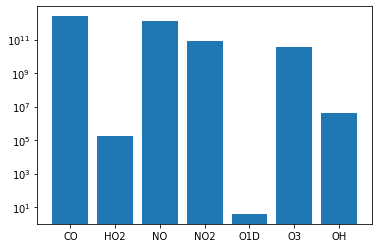

In [129]:
# execute this cell as many times as you like to manually step the simulation forward
toy_concs = step_fwd(toy_concs, delt)
plt.bar(["CO", "HO2", "NO", "NO2", "O1D", "O3", "OH"], toy_concs)
plt.yscale("log")
print(toy_concs)

In [117]:
@jit
def do_sim(initconcs, tend, delt, tsave):
    """
    runs simulation
    """
    save_concs, concs = init(initconcs, tend, tsave)
    for T in save_concs.index[1:]:
        clear_output()
        print(f"Simulating: {round(T / tend * 100, 3)}%")
        for t in np.arange(0, tsave, delt):
            concs = step_fwd(concs, delt)
        #print(f"concs at {T} seconds: {concs.values[0]}")
        save_concs.loc[T] = concs
    clear_output()
    print("Simulation complete")
    return save_concs

### Part D 

Iterate your eqs forward in time on the computer, using the initial conditions IC and specifications given below.

In [45]:
# full simulation (as spec'd by time step info in cell 1)
concs_out = do_sim(initconcs, tend, delt, tsave)

Simulation complete


### Part E(a)

Using your output saved from D, convert the concentrations of the following 4 variables from $c$ (molecules/cm$^3$) to mixing ratio $q$ (ppm) using the following approximate formula:

$$
q \text{ (ppm)} = c\text{ (molecules/cm}^3\text{)} \cdot (4.0e-14)
$$

In [136]:
concs_ppm = concs_out * 4e-14

### Part E(b)

Plot on the same one graph the following 4 concentration curves in units of ppm:  ppm_CO, ppm_NO, ppm_NO2, ppm_O3
 versus time in hours.  (Plot them only at intervals as given below
 in the specs. 

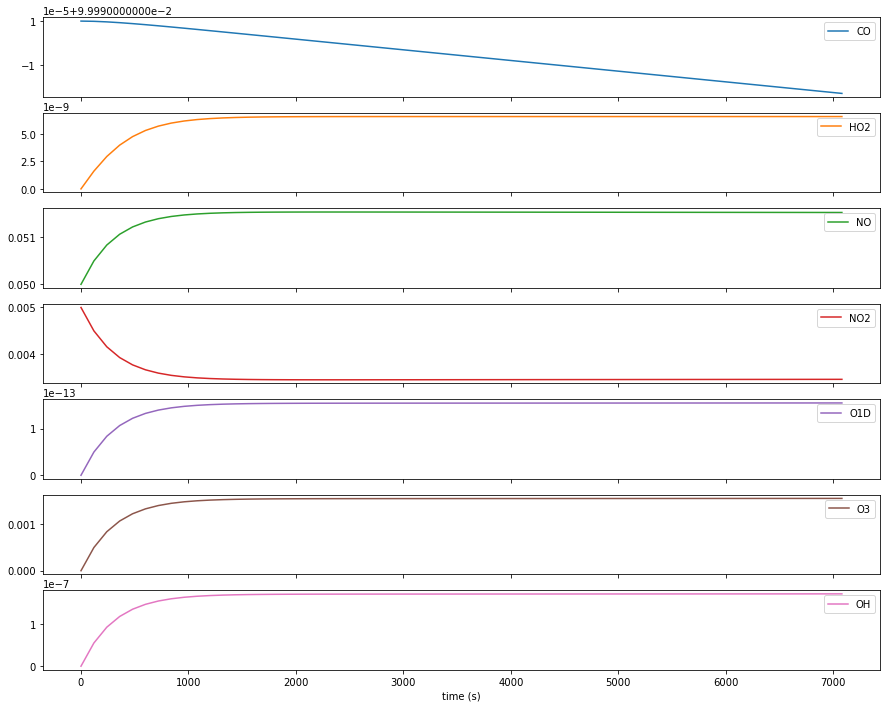

In [137]:
concs_ppm.plot(figsize=(15,12), subplots=True, xlabel="time (s)");

### Part F

Discuss the significance of your results from E.

*is this working correctly?*